In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import ( complete_meas_cal , CompleteMeasFitter )
%matplotlib inline

In [2]:
# qiskit.__qiskit_version__

In [3]:
# IBMQ.save_account('8f371c4cd9299d2d47d8fb8921b3ac568ddd7ee69f1677c378224aa662e56d67b1753e0117ec71562b7da34ef2f73fd82b316664e2ab8fa8dc3827a626ebfe75')

In [4]:
IBMQ.load_account()

c:\users\acer\appdata\local\programs\python\python38\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
theta = 0.05
shots=1e3
g= 5

In [6]:
qr_1 = QuantumRegister(4)
cr_1 = ClassicalRegister(4)
circuit_1 = QuantumCircuit(qr_1,cr_1)

circuit_1.ry(2*theta,0)
circuit_1.ch(0,1)

circuit_1.ry(2*theta,2)
circuit_1.ch(2,3)
circuit_1.h(2)

circuit_1.measure([0,1,2,3],[0,1,2,3])

In [8]:
qr_2 = QuantumRegister(4)
cr_2 = ClassicalRegister(4)
circuit_2 = QuantumCircuit(qr_2,cr_2)

circuit_2.ry(2*theta,0)
circuit_2.ch(0,1)
circuit_2.h(0)
circuit_2.h(1)

circuit_2.ry(2*theta,2)
circuit_2.ch(2,3)
circuit_2.rx(np.pi/2,2)
circuit_2.rx(np.pi/2,3)

circuit_2.measure([0,1,2,3],[0,1,2,3])

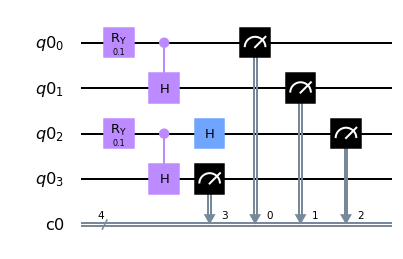

In [33]:
%matplotlib inline
circuit_1.draw(output='mpl')

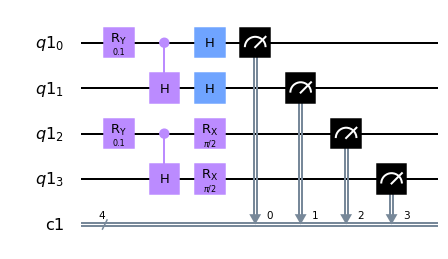

In [34]:
circuit_2.draw(output='mpl')

In [10]:
QC_type =0
if QC_type == 0:
    provider = IBMQ.get_provider('ibm-q')
    backend = provider.get_backend('ibmq_5_yorktown') # Quantum Computer
else: 
    backend = Aer.get_backend('qasm_simulator') # Quantum Simulator

In [11]:
job_1 = execute(circuit_1, backend, shots=shots)
job_monitor(job_1)

Job Status: job has successfully run


In [12]:
job_2 = execute(circuit_2, backend, shots=shots)
job_monitor(job_2)

Job Status: job has successfully run


In [13]:
print([ job_1.job_id() , job_2.job_id() ])

['605f6794dab16c99d14fd4bc', '605f67a0d5f9d63e66f764e5']


In [14]:
result_1 = job_1.result()
result_2 = job_2.result()
device_counts_1 = result_1.get_counts(circuit_1)
device_counts_2 = result_2.get_counts(circuit_2)

In [15]:
cal_circuits , state_labels = complete_meas_cal( qr = circuit_1.qregs[0] , circlabel = 'mitigation')

In [16]:
cal_job = execute(cal_circuits,
                 backend = backend,
                 shots = 1000,
                 optimization_level=0)
print(cal_job.job_id())
job_monitor(cal_job)

605f67ad7d904d8fc21ea3dd
Job Status: job has successfully run


In [17]:
cal_results = cal_job.result()

In [18]:
meas_fitter = CompleteMeasFitter(cal_results , state_labels)

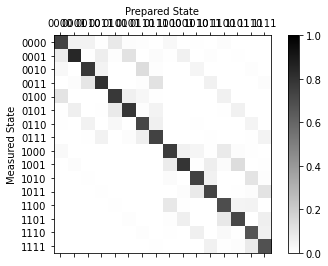

In [19]:
meas_fitter.plot_calibration()

In [20]:
meas_filter = meas_fitter.filter

In [21]:
mitigated_result_1 = meas_filter.apply(result_1)
mitigated_result_2 = meas_filter.apply(result_2)

In [22]:
mitigated_counts_1 = mitigated_result_1.get_counts(circuit_1)
mitigated_counts_2 = mitigated_result_2.get_counts(circuit_2)

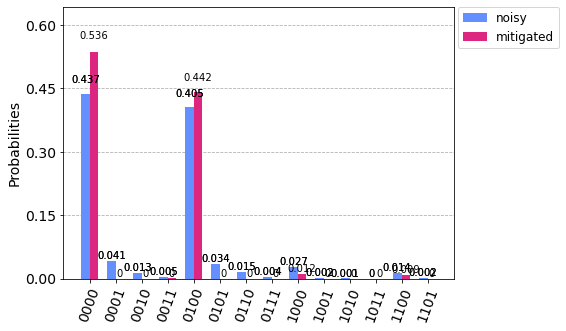

In [23]:
plot_histogram([device_counts_1,mitigated_counts_1],legend=['noisy','mitigated'])

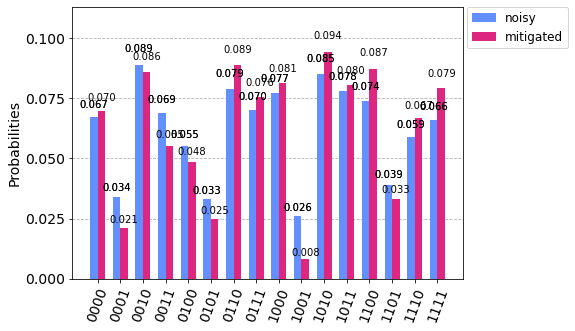

In [24]:
plot_histogram([device_counts_2,mitigated_counts_2],legend=['noisy','mitigated'])

In [25]:
def prob_1(block,qq,counts,shots):
    if block == 'ii':
        [i,j] = [2,3]
    elif block == 'ix':
        [i,j] = [0,1]
        
    P=0
    for k in list(counts.keys()): 
        pieces = []
        for n in range(len(k)):
            pieces.append(k[n])
        if str(pieces[i])+str(pieces[j]) == qq:
            P += counts[k]
    return P / shots

def prob_2(block,qq,counts,shots):
    if block == 'xx':
        [i,j] = [2,3]
    elif block == 'yy':
        [i,j] = [0,1]
        
    P=0
    for k in list(counts.keys()): 
        pieces = []
        for n in range(len(k)):
            pieces.append(k[n])
        if str(pieces[i])+str(pieces[j]) == qq:
            P += counts[k]
    return P / shots

In [26]:
def Hamiltonian(theta,counts_1,counts_2,shots=1024,g=1):
    P_00 = prob_1('ii','00',counts=counts_1,shots=shots) 
    
    Pix_00 = prob_1('ix','00',counts=counts_1,shots=shots)
    Pix_10 = prob_1('ix','10',counts=counts_1,shots=shots)
    
    Pzx_00 = prob_1('ix','00',counts=counts_1,shots=shots)
    Pzx_11 = prob_1('ix','11',counts=counts_1,shots=shots)

    
    Pxx_00 = prob_2('xx','00',counts=counts_2,shots=shots)
    Pxx_11 = prob_2('xx','11',counts=counts_2,shots=shots)

    Pyy_00 = prob_2('yy','00',counts=counts_2,shots=shots)
    Pyy_11 = prob_2('yy','11',counts=counts_2,shots=shots)

    #hamiltonian
    H_E = 3*(1 - P_00)
    H_B = (1/2)*( 5*(Pxx_00 + Pxx_11) + 5*(Pix_00 + Pix_10) + 3*(Pzx_00 + Pzx_11) - 3*(Pyy_00 + Pyy_11) -5)
    H = (g**2 /2)*H_E - (1/(2*g**2))*H_B
    return H 

In [27]:
H = Hamiltonian(theta,counts_1=device_counts_1,counts_2=device_counts_2,shots=shots,g=g)
H_mitigated = Hamiltonian(theta,counts_1=mitigated_counts_1,counts_2=mitigated_counts_2,shots=shots,g=g)

In [28]:
f = open("mitigated_g_5.txt",'a+')
item = [theta,H,H_mitigated]
f.write( "%r\n" %item )
f.close() 

In [29]:
import winsound
duration = 1000  # milliseconds
freq = 200  # Hz
winsound.Beep(freq, duration)